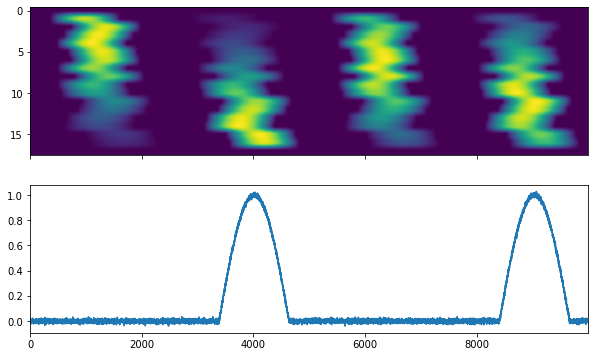

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nems import Model
from nems.layers.base import Layer
from nems.layers import GaussianWeightChannels, FIR, DoubleExponential
from nems.distributions import Normal

# Generate a fake "spectrogram"
one_channel = (np.arange(10000)/400)[..., np.newaxis]
all_channels = [np.roll(one_channel, 300+i*20, axis=0) for i in range(18)]
spectrogram =  np.sin(np.concatenate(all_channels, axis=1))
# Zero out extremes
spectrogram[:,0] = 0
spectrogram[:,17] = 0
# Rectify
spectrogram = spectrogram * (spectrogram > 0)

# Multiply by gaussians (along channel axis) that are at different
# positions across time, so that each "sound" has a different
# center frequency
x = np.arange(18)/18
mean = np.array([[0.2], [0.8], [0.35], [0.6]])
sd = np.ones(shape=(4,1))/3
coefficients = np.exp(-0.5*((x-mean)/sd)**2)
for i in range(4):
    c = coefficients[i, :]
    first, last = (i*2500, (i+1)*2500)
    spectrogram[first:last, :] = spectrogram[first:last, :]*c

# Add some jitter in time
jitter = np.random.rand(18)*500
for i in range(18):
    spectrogram[:, i] = np.roll(spectrogram[:, i], int(jitter[i]), axis=0)

# And a fake "response"
resp = np.cos(np.roll((np.arange(10000)/400)[..., np.newaxis], 1500, axis=0))
resp = resp * (resp > 0)
# Zero out first and third peaks, to respond to only some frequency ranges
resp[0:2500] = 0
resp[5000:7500] = 0
# Add some white noise
sample = Normal(mean=0, sd=1).sample(n=10000)[..., np.newaxis]/100
resp += sample

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,6))
ax1.imshow(spectrogram.T, aspect='auto')
ax2.plot(resp)

In [2]:
# DummyLayer just demonstrates/tests re-defining `Layer.plot``,
# it doesn't affect the model prediction.
class DummyLayer(Layer):
    def evaluate(self, *inputs):
        return inputs  # passthrough
    def plot(self, output, fig, **kwargs):
        # fig should be a subfigure of model figure
        n_chans = output[0].shape[1]
        fig.subplots(n_chans, 1)
        colors = plt.cm.rainbow(np.linspace(0, 1, n_chans))
        for x in output:
            # one channel per subplot, repeated if multiple outputs
            for i, ax in enumerate(fig.axes):
                ax.plot(x[:,i], c=colors[i])
    @property
    def plot_options(self):
        return {'show_y': False}

model = Model()
model.add_layers(
    GaussianWeightChannels(shape=(18,4)),
    DummyLayer(),
    FIR(shape=(4,25)),
    DoubleExponential(shape=())
)

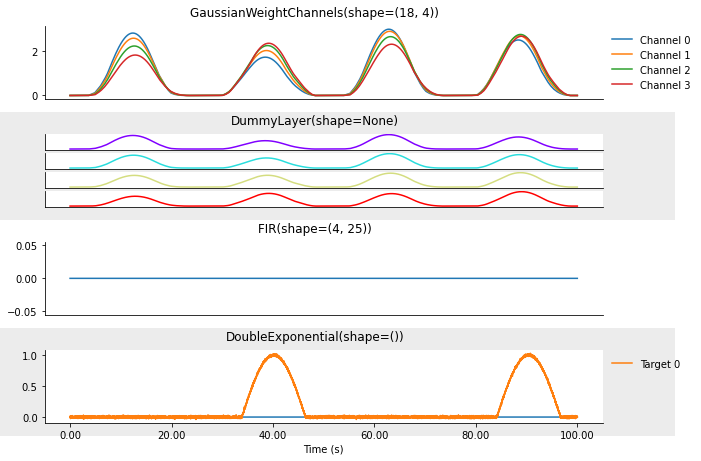

In [3]:
fig2 = model.plot(spectrogram, target=resp, sampling_rate=100,
                  figure_kwargs={'figsize': (10,6)})

In [7]:
# Fit the model, so that the last layer's output (should) look like resp
# If the fit is awful, try re-evaluating this cell to start from new initial
# conditions. I usually get a decent one within 2-3 tries.
model.sample_from_priors()
model.fit(spectrogram, resp)

iteration 0, error is: 0.09236051...
iteration 5, error is: 0.06283559...
iteration 10, error is: 0.04450327...
iteration 15, error is: 0.01245489...
iteration 20, error is: 0.00719766...
iteration 25, error is: 0.00716518...
iteration 30, error is: 0.00715732...
iteration 35, error is: 0.00715708...
iteration 40, error is: 0.00715301...
iteration 45, error is: 0.00715246...
iteration 50, error is: 0.00714899...
iteration 55, error is: 0.00714795...
iteration 60, error is: 0.00713948...
iteration 65, error is: 0.00706884...
iteration 70, error is: 0.00706119...
iteration 75, error is: 0.00706041...
iteration 80, error is: 0.00704114...
iteration 85, error is: 0.00699784...
iteration 90, error is: 0.00697590...
iteration 95, error is: 0.00696872...


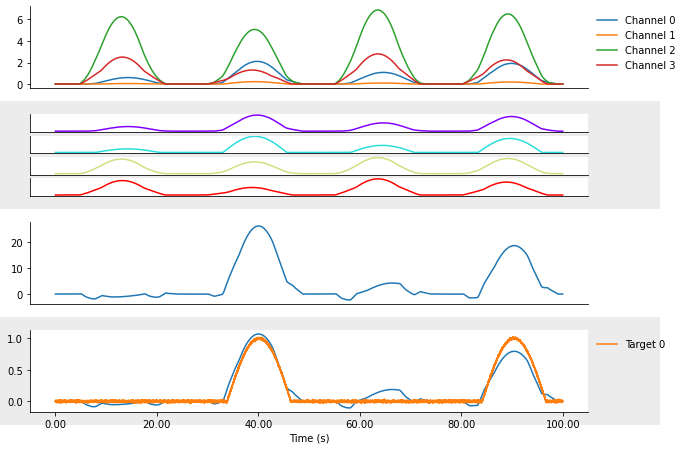

In [8]:
fig3 = model.plot(spectrogram, target=resp, sampling_rate=100,
                  figure_kwargs={'figsize': (10,6)})